In [ ]:
#Importin libraries

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import re
import emoji

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [8]:
train_df = pd.read_csv("twitter_training.csv", header=None)
val_df = pd.read_csv("twitter_validation.csv", header=None)

In [9]:
print("Training shape:", train_df.shape)
print("Validation shape:", val_df.shape)

Training shape: (74682, 4)
Validation shape: (1000, 4)


In [10]:
train_df.columns = ['tweet_id', 'entity', 'sentiment', 'content']
val_df.columns = ['tweet_id', 'entity', 'sentiment', 'content']

In [11]:
print("\nColumn Names:")
print(train_df.columns)


Column Names:
Index(['tweet_id', 'entity', 'sentiment', 'content'], dtype='object')


In [12]:
print("\nTraining Data Head:")
print(train_df.head())


Training Data Head:
   tweet_id       entity sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   

                                             content  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  


In [13]:
#Pre-process data

In [14]:
print(f"\nDuplicates in training data: {train_df.duplicated().sum()}")
train_df = train_df.drop_duplicates().reset_index(drop=True)

print(f"\nNaN values in training data:\n{train_df.isna().sum()}")
train_df = train_df.dropna().reset_index(drop=True)


Duplicates in training data: 2700

NaN values in training data:
tweet_id       0
entity         0
sentiment      0
content      326
dtype: int64


In [15]:
def preprocess_text(text):
    text = str(text).lower()                                # lowercase
    text = re.sub(r"http\\S+|www\\S+|https\\S+", '', text)     # remove urls
    text = re.sub(r"@\\w+|#\\w+", '', text)                   # remove mentions & hashtags
    text = re.sub(r"[0-9]+", '', text)                      # remove numbers
    text = re.sub(r"[^\\w\\s]", '', text)                     # remove punctuation
    text = emoji.replace_emoji(text, replace='')            # remove emojis
    text = re.sub(r"\\s+", ' ', text).strip()                # remove extra spaces
    return text

In [16]:
print("\nPreprocessing text...")
train_df['content'] = train_df['content'].apply(preprocess_text)
val_df['content']   = val_df['content'].apply(preprocess_text)

print("Preprocessing complete.")
print(train_df.head())


Preprocessing text...
Preprocessing complete.
   tweet_id       entity sentiment content
0      2401  Borderlands  Positive      sw
1      2401  Borderlands  Positive      sw
2      2401  Borderlands  Positive      sw
3      2401  Borderlands  Positive      sw
4      2401  Borderlands  Positive      sw


In [17]:
#Label encoding

In [18]:
label_encoder = LabelEncoder()

In [19]:
train_df['sentiment'] = label_encoder.fit_transform(train_df['sentiment'])
val_df['sentiment'] = label_encoder.transform(val_df['sentiment'])

In [38]:
train_df.head()

,tweet_id,entity,sentiment,content
0,2401,Borderlands,3,sw
1,2401,Borderlands,3,sw
2,2401,Borderlands,3,sw
3,2401,Borderlands,3,sw
4,2401,Borderlands,3,sw


In [20]:
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print(f"\nLabel classes: {label_encoder.classes_}")


Label classes: ['Irrelevant' 'Negative' 'Neutral' 'Positive']


In [21]:
tfidf = TfidfVectorizer(max_features=5000)

In [23]:
print("\nFitting TF-IDF vectorizer...")
x_train_tfidf = tfidf.fit_transform(train_df['content']).toarray()
x_val_tfidf = tfidf.transform(val_df['content']).toarray()
print(f"TF-IDF training data shape: {x_train_tfidf.shape}")


Fitting TF-IDF vectorizer...
TF-IDF training data shape: (71656, 5000)


In [24]:
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

# --- Prepare labels for sklearn model ---
y_train = train_df['sentiment'].values
y_val = val_df['sentiment'].values

In [25]:
#Model Training

In [26]:
sk_model = LogisticRegression(max_iter=1000, random_state=42)

In [27]:
sk_model.fit(x_train_tfidf, y_train)

print("Model training complete.")

Model training complete.


In [28]:
with open("sklearn_logistic_model.pkl", "wb") as f:
    pickle.dump(sk_model, f)

In [29]:
#Evaluate

In [30]:
# Get predictions on the validation set
y_pred_classes = sk_model.predict(x_val_tfidf)

In [31]:
print("\nClassification Report:")
print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.54      0.08      0.14       172
    Negative       0.33      0.67      0.44       266
     Neutral       0.49      0.28      0.36       285
    Positive       0.38      0.38      0.38       277

    accuracy                           0.38      1000
   macro avg       0.44      0.35      0.33      1000
weighted avg       0.43      0.38      0.35      1000



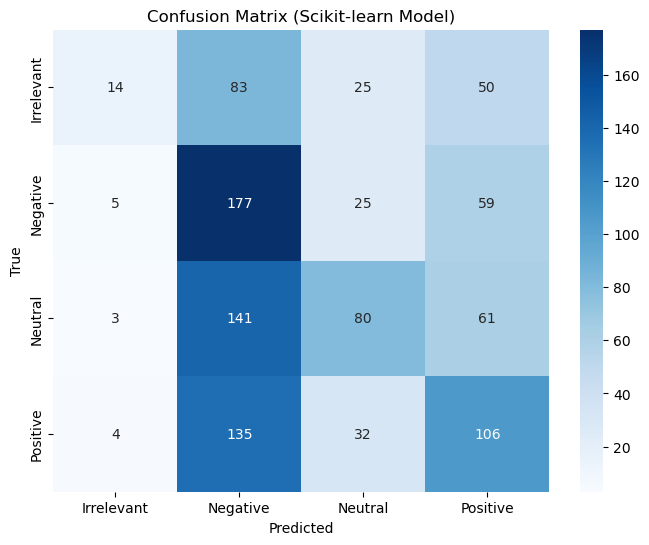

In [34]:
# --- Confusion Matrix ---
conf_matrix = confusion_matrix(y_val, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Scikit-learn Model)')
plt.show()

In [35]:
#Testing the model

In [36]:
print("\nTesting model with new, unseen text...")

texts = [
    "I love this product!",
    "This is terrible.",
    "The game is okay, nothing special.",
    "This has nothing to do with anything."
]


Testing model with new, unseen text...


In [37]:
preprocessed_texts = [preprocess_text(t) for t in texts]

# Transform the text using the *fitted* TF-IDF vectorizer
x_input = tfidf.transform(preprocessed_texts).toarray()

# Predict using the trained sklearn model
y_pred_probs = sk_model.predict(x_input)
predicted_labels = label_encoder.inverse_transform(y_pred_probs)

print("\n--- Test Results ---")
for text, label in zip(texts, predicted_labels):
    print(f"Text: '{text}'\nPredicted: {label}\n")


--- Test Results ---
Text: 'I love this product!'
Predicted: Negative

Text: 'This is terrible.'
Predicted: Positive

Text: 'The game is okay, nothing special.'
Predicted: Positive

Text: 'This has nothing to do with anything.'
Predicted: Positive

